##  Analysis of a claim
To Check on Checkability, the first workflow of the EUFactcheck programme will be followed (https://eufactcheck.eu/about-us/eufactcheck-flowchart/). The student will also be involved to provide more information and to check the output.

In [1]:
import getpass
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
#from langchain_ollama import ChatOllama
import tqdm as notebook_tqdm
from tavily import TavilyClient
import sys
import os

# Load alle the API keys
load_dotenv(dotenv_path=".env", override=True)

# Initialize Tavily client 
tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY", ""))

#os.environ["LANGSMITH_TRACING"] = "true"
#os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
#os.environ["LANGSMITH_PROJECT"]="pr-left-technician-100"

#low temperature for more factual answers,
#llm = ChatOllama(model="qwen3:4b", temperature=0.1, base_url="http://localhost:11434")
llm = ChatGroq(model_name="qwen/qwen3-32b", temperature=0.1)

sys.path.append(os.path.abspath("./src"))

c:\temp\checkmate\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functions of all the nodes in Claim analysis

These functions are all the nodes in the claim graph and also show the edges in case of conditional nodes

In [2]:
""" All the nodes """

from langchain_core.messages import BaseMessage,HumanMessage,AIMessage,get_buffer_string
from prompts import (
    checkable_check_prompt,
    confirmation_checkable_prompt,
    get_information_prompt,
    confirmation_clarification_prompt,
    get_summary_prompt,
    confirmation_check_prompt,
    retrieve_claims_prompt,
    match_check_prompt,
    identify_source_prompt,
    primary_source_prompt,
    select_primary_source_prompt,
    research_prompt,
    get_socratic_question,
)
from state_scope import (
    AgentStateClaim, 
    SubjectResult, 
    MoreInfoResult, 
    SummaryResult, 
    ConfirmationResult,
    ConfirmationFinalResult,
    ConfirmationMatch, 
    GetSource, 
    PrimarySourcePlan, 
    PrimarySourceSelection, 
    ResearchPlan
)
from typing_extensions import Literal, List
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Command
from utils import get_new_user_reply
from tooling import llm, llm_tools, llm_tuned, tools_dict
import json

# Maximum number of messages to send to the prompt
MAX_HISTORY_MESSAGES = 6
# ───────────────────────────────────────────────────────────────────────
# ROUTER NODE
# ───────────────────────────────────────────────────────────────────────
def router(state: AgentStateClaim) -> Command[
    Literal[
        "checkable_fact",
        "checkable_confirmation",
        "retrieve_information",
        "clarify_information",
        "produce_summary",
        "critical_question",
        "get_confirmation",
        "claim_matching",
        "match_or_continue",
        "get_source",
        "get_primary_source",
        "locate_primary_source",
        "select_primary_source",
        "research_claim"]
]:
    """ Route to correct node, after user reply """

    nn = state.get("next_node")
    return Command(goto=nn or "checkable_fact")

# ───────────────────────────────────────────────────────────────────────
# CHECKABLE_FACT NODE
# ───────────────────────────────────────────────────────────────────────

def checkable_fact(state: AgentStateClaim) -> Command[Literal["checkable_confirmation"]]:

    """ Check if a claim is potentially checkable. """

    #Retrieve conversation history
    conversation_history = list(state.get("messages", []))

    # Add the last message into a string for the prompt
    recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
    messages_str = get_buffer_string(recent_messages)

    # Use structured output
    structured_llm = llm.with_structured_output(SubjectResult, method="json_mode")

    # Create a prompt
    prompt = checkable_check_prompt.format(
        claim=state.get("claim", ""),
        messages=messages_str,
    )

    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])

    # checkable is a boolean in State
    is_checkable = result.checkable == "POTENTIALLY CHECKABLE"

    # human-readable assistant message for the chat
    explanation_text = (
        f"**Checkability analysis**\n"
        f"- Checkable: `{result.checkable}`\n"
        f"- Reason: {result.explanation}\n"
    )

    ai_chat_msg = AIMessage(content=explanation_text)

    # Goto next node and update State
    return Command(
        goto="checkable_confirmation", 
        update={
            "question": result.question,
            "checkable": is_checkable,
            "explanation": result.explanation,
            "messages": [ai_chat_msg],
            "awaiting_user": True,
            "next_node": None,
        }
    )

# ───────────────────────────────────────────────────────────────────────
# CHECKABLE_CONFIRMATION NODE
# ───────────────────────────────────────────────────────────────────────

def checkable_confirmation(state: AgentStateClaim) -> Command[Literal["retrieve_information","__end__","checkable_fact"]]:
    
    """ Get confirmation from user on the gathered information. """

    if state.get("awaiting_user"):

        ask_msg = AIMessage(content=state.get("question", ""))
        return Command(
            goto="__end__", 
            update={
                "messages": [ask_msg],
                "next_node": "checkable_confirmation",
                "awaiting_user": False,
            },
        )
    else:
        # Retrieve conversation history
        conversation_history = list(state.get("messages", []))

        # Get user reply, if the last message was a user message
        user_answer = get_new_user_reply(conversation_history)

        # Use structured output
        structured_llm = llm.with_structured_output(ConfirmationResult, method="json_mode")

        # Create a prompt
        prompt = confirmation_checkable_prompt.format(
            claim=state.get("claim", ""),
            checkable=state.get("checkable", ""),
            explanation=state.get("explanation", ""),
            user_answer=user_answer,
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])
        
        # human-readable assistant message for the chat
        if result.confirmed:
            confirm_text = "We'll continue with this claim."
        else:
            confirm_text = "Okay let's revise the claim or stop here."

        ai_chat_msg = AIMessage(content=confirm_text)

        # Goto next node and update State
        if result.confirmed:
            if state.get("checkable"):
                return Command(
                        goto="retrieve_information", 
                        update={
                            "confirmed": result.confirmed,
                            "messages": [ai_chat_msg],
                            "awaiting_user": False,
                            "next_node": None
                        }
                )   
            else: 
                # user confirmed but claim is not checkable → end
                end_msg = AIMessage(content="This claim appears to be uncheckable, so we'll stop the process here.")
                return Command(
                        goto=END, 
                        update={
                            "confirmed": result.confirmed,
                            "messages": [ai_chat_msg] + [end_msg],
                            "awaiting_user": False,
                            "next_node": None
                        }
                )   
        else:
            return Command(
                    goto="checkable_fact", 
                    update={
                        "messages": [ai_chat_msg],
                        "awaiting_user": False,
                        "next_node": None
                    }
            )

# ───────────────────────────────────────────────────────────────────────
# RETRIEVE_INFORMATION NODE
# ───────────────────────────────────────────────────────────────────────

def retrieve_information(state: AgentStateClaim) -> Command[Literal["clarify_information"]]:

    """ Gather more information about a potentially checkable claim. """

    #Retrieve conversation history
    conversation_history = list(state.get("messages", []))

    # Add the last message into a string for the prompt
    recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
    messages_str = get_buffer_string(recent_messages)

    # Use structured output
    structured_llm = llm.with_structured_output(MoreInfoResult, method="json_mode")

    # Create a prompt
    prompt  =  get_information_prompt.format(
        claim=state.get("claim", ""),
        messages=messages_str,
    )

    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])

    # human-readable assistant message for the chat
    details_text = (
        "**Here’s what I extracted from your claim:**\n"
        f"- Subject: {result.subject or 'not clearly specified'}\n"
        f"- Quantitative: {result.quantitative}\n"
        f"- Precision: {result.precision}\n"
        f"- Based on: {result.based_on}\n"
    )

    if result.alerts:
        details_text += "\n**Missing / to verify:**\n" + "\n".join(f"- {a}" for a in result.alerts)

    ai_chat_msg = AIMessage(content=details_text)

    # Goto next node and update State
    return Command(
        goto="clarify_information", 
        update={
            "subject": result.subject,
            "quantitative": result.quantitative,
            "precision": result.precision,
            "based_on": result.based_on,
            "question": result.question,
            "alerts": result.alerts or [],
            "messages": [ai_chat_msg],
            "awaiting_user": True,
            "next_node": None,
        }
    )   

# ───────────────────────────────────────────────────────────────────────
# CLARIFY_INFORMATION NODE
# ───────────────────────────────────────────────────────────────────────

def clarify_information(state: AgentStateClaim) -> Command[Literal["produce_summary", "retrieve_information"]]:

    """ Get confirmation from user on the gathered information. """

    if state.get("awaiting_user"):

        ask_msg = AIMessage(content=state.get("question", ""))
        return Command(
            goto="__end__", 
            update={
                "messages": [ask_msg],
                "next_node": "clarify_information",
                "awaiting_user": False,
            },
        )
    else:

        #retrieve alerts and format to string for the prompt
        alerts=state.get("alerts", [])
        alerts_str= "\n".join(f"- {a}" for a in alerts)

        # retrieve conversation history
        conversation_history = list(state.get("messages", []))
        user_answer = get_new_user_reply(conversation_history)

        # Add the last message into a string for the prompt
        recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
        messages_str = get_buffer_string(recent_messages)

        # Use structured output
        structured_llm = llm.with_structured_output(ConfirmationResult, method="json_mode")

        # Create a prompt
        prompt  =  confirmation_clarification_prompt.format(
            subject=state.get("subject", ""),
            quantitative=state.get("quantitative", ""),
            precision=state.get("precision", ""),
            based_on=state.get("based_on", ""),
            claim=state.get("claim", ""),
            question=state.get("question", ""),
            alerts=alerts_str,
            messages=messages_str,
            user_answer=user_answer,
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])

        # human-readable assistant message for the chat
        if result.confirmed:
            confirm_text = "Thanks, I’ll use this information to draft the summary."
        else:
            confirm_text = "Let’s collect a bit more information."

        ai_chat_msg = AIMessage(content=confirm_text)

        # Goto next node and update State
        if result.confirmed:
            return Command(
                    goto="produce_summary", 
                    update={
                        "confirmed": result.confirmed,
                        "messages": [ai_chat_msg],
                        "next_node": None,
                    }
            )       
        else:
            return Command(
                    goto="retrieve_information", 
                    update={
                        "messages": [ai_chat_msg],
                        "next_node": None,
                    }
            )

# ───────────────────────────────────────────────────────────────────────
# PRODUCE SUMMARY NODE
# ───────────────────────────────────────────────────────────────────────

def produce_summary(state: AgentStateClaim) -> Command[Literal["get_confirmation"]]:

    """ Get a summary on the gathered information. """

    # retrieve alerts and format to string for the prompt
    alerts=state.get("alerts", [])
    alerts_str= "\n".join(f"- {a}" for a in alerts)

    # retrieve conversation history
    conversation_history = list(state.get("messages", []))

    # Add the last message into a string for the prompt
    recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
    messages_str = get_buffer_string(recent_messages)

    # Use structured output
    structured_llm = llm.with_structured_output(SummaryResult, method="json_mode")

    # Create a prompt
    prompt  =  get_summary_prompt.format(
        claim=state.get("claim", ""),
        subject=state.get("subject", ""),
        quantitative=state.get("quantitative", ""),
        precision=state.get("precision", ""),
        based_on=state.get("based_on", ""),
        alerts=alerts_str,
        messages=messages_str,
    )

    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=prompt)])

    # human-readable assistant message for the chat
    summary_text = (
        f"**Summary of our findings so far:**\n\n{result.summary}\n\n"
    )
    if result.question:
        summary_text += f"**Next step / question:** {result.question}\n"

    ai_chat_msg = AIMessage(content=summary_text)

    # Goto next node and update State
    return Command( 
            goto="get_confirmation",
            update={
                "summary": result.summary,
                "question": result.question,
                "messages": [ai_chat_msg],
                "subject": result.subject,
                "quantitative": result.quantitative,
                "precision": result.precision,
                "based_on": result.based_on,
                "alerts": result.alerts or [],
                "awaiting_user": True,
            }
    )       

# ───────────────────────────────────────────────────────────────────────
# GET_CONFIRMATION NODE
# ───────────────────────────────────────────────────────────────────────
   
def get_confirmation(state: AgentStateClaim) -> Command[Literal["produce_summary", "critical_question"]]:

    """ Get confirmation from user on the gathered information."""

    if state.get("awaiting_user"):

        ask_msg = AIMessage(content=state.get("question", []))
        return Command(
            goto="__end__", 
            update={
                "messages": [ask_msg],
                "next_node": "get_confirmation",
                "awaiting_user": False,
            },
        )
    else:
        # retrieve conversation history
        conversation_history = list(state.get("messages", []))
        user_answer = get_new_user_reply(conversation_history)

        # Use structured output
        structured_llm = llm.with_structured_output(ConfirmationFinalResult, method="json_mode")

        # Create a prompt
        prompt  =  confirmation_check_prompt.format(
            summary=state.get("summary", ""),
            user_answer=user_answer,
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])

        # human-readable assistant message for the chat
        if result.confirmed:
            confirm_text = "Do you want to continue? (Yes/ No)"
        else:
            confirm_text = "Let's revisit the summary and adjust it if needed."

        ai_chat_msg = AIMessage(content=confirm_text)

        if result.confirmed:
            return Command(
                    goto="critical_question", 
                    update={
                        "confirmed": result.confirmed,
                        "subject": result.subject,
                        "quantitative": result.quantitative,
                        "precision": result.precision,
                        "based_on": result.based_on,
                        "question": result.question,
                        "alerts": result.alerts or [],
                        "messages": [ai_chat_msg],
                        "next_node": None,
                    }
            )       
        else:
            return Command(
                    goto="produce_summary", 
                    update={
                        "messages": [ai_chat_msg],
                        "subject": result.subject,
                        "quantitative": result.quantitative,
                        "precision": result.precision,
                        "based_on": result.based_on,
                        "question": result.question,
                        "alerts": result.alerts or [],
                        "next_node": None,
                    }
            )

# ───────────────────────────────────────────────────────────────────────
# CRITICAL QUESTION NODE
# ───────────────────────────────────────────────────────────────────────

def critical_question(state: AgentStateClaim) -> Command[Literal["claim_matching"]]:

    """ Ask a socratic question to make the user think about the consequences of a fact checking a claim """

    # retrieve alerts and format to string for the prompt
    alerts=state.get("alerts", [])
    alerts_str= "\n".join(f"- {a}" for a in alerts)

    # retrieve conversation history fact-check messages and critical messages
    conversation_history = list(state.get("messages", []))
    conversation_history_critical = list(state.get("messages_critical", []))

    # Add the last messages into a string for the prompt
    recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
    messages_str = get_buffer_string(recent_messages)
    recent_messages_critical = conversation_history_critical[-MAX_HISTORY_MESSAGES:]  # tune this number
    messages_critical_str = get_buffer_string(recent_messages_critical)

    # Create a prompt
    prompt  =  get_socratic_question.format(
        claim=state.get("summary", ""),
        alerts=alerts_str,
        messages=messages_str,
        messages_critical=messages_critical_str 
    )

    #invoke the LLM and store the output
    result = llm.invoke([HumanMessage(content=prompt)])

    question_text = getattr(result, "content", str(result))

    # Goto next node and update State
    return Command( 
            goto="claim_matching",
            update={
                "question": question_text,
                "messages_critical": [AIMessage(content=question_text)],
             }
    )       

# ───────────────────────────────────────────────────────────────────────
# CLAIM MATCHING NODE
# ───────────────────────────────────────────────────────────────────────

def claim_matching(state: AgentStateClaim) -> Command[Literal["match_or_continue"]]:

    """ Call the retriever tool iteratively to find if similar claims have already been researched. """

    # retrieve conversation history
    conversation_history = list(state.get("messages", []))

    # Add the last message into a string for the prompt
    recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
    messages_str = get_buffer_string(recent_messages)

    #Create a prompt
    prompt = retrieve_claims_prompt.format(
        summary=state.get("summary", ""),
        subject=state.get("subject", ""),
        messages=messages_str,
    )

    # Start with a single HumanMessage
    human = HumanMessage(content=prompt)

    # First model call: only the prompt
    result = llm_tools.invoke([human])

    # Iterate tool calls
    while getattr(result, "tool_calls", None):

        # empty tool messages list to contain tool outputs
        tool_msgs: List[ToolMessage] = []

        # loop over each tool call
        for t in result.tool_calls:
            name = t["name"]
            args = t.get("args") or {}

            # invoke the tool
            out = tools_dict[name].invoke(args)

            # append tool output as ToolMessage
            tool_msgs.append(
                ToolMessage(
                    tool_call_id=t["id"],
                    name=name,
                    content=str(out),
                )
            )

        # Next model call, and decide if more tool calls are needed
        result = llm_tools.invoke([human, result, *tool_msgs])
    
    # Goto next node and update State
    return Command( 
        goto="match_or_continue",
        update={
            "messages": [human, result],
            "awaiting_user": True,
            "next_node": "match_or_continue",
        }
    )

# ───────────────────────────────────────────────────────────────────────
# MATCHED OR CONTUE RESEARCH NODE
# ───────────────────────────────────────────────────────────────────────

def match_or_continue(state: AgentStateClaim) -> Command[Literal["get_source", "__end__"]]:

    """ Decide whether to continue researching or end the process if a matching claim was found."""

    print(f"hier match and continue{state.get("next_node")} en {state.get("awaiting_user")}")
    if state.get("awaiting_user"):
        ask_msg = AIMessage(content="Do any of these match your claim? Or do you want to continue researching as suggested?")
        return Command(
            goto="__end__", 
            update={
                "messages": [ask_msg],
                "next_node": "match_or_continue",
                "awaiting_user": False,
            },
        )
    else:
        # retrieve conversation history
        conversation_history = list(state.get("messages", []))
        user_answer = get_new_user_reply(conversation_history)

        # Add the last message into a string for the prompt
        recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
        messages_str = get_buffer_string(recent_messages)

        # Use structured output
        structured_llm = llm.with_structured_output(ConfirmationMatch, method="json_mode")

        # Create a prompt
        prompt =  match_check_prompt.format(
            messages=messages_str,
            user_answer=user_answer,
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])

        # # human-readable assistant message for the chat
        if result.match:
            ai_chat_msg = AIMessage(
                content=(
                    "This claim appears to match an already researched claim. "
                    "We can stop the process here."
                )
            )
        else:
            ai_chat_msg = AIMessage(
                content=(
                    "No exact match found. Let's continue researching.\n"
                    "Do you have a URL for the source of the claim? If so, please share it.\n"
                    "If not, tell me who made the claim and in what medium (article, video, social media, etc.)."
                )
            )
        
        # Goto next node and update State
        if result.match:
            return Command(
                    goto="__end__", 
                    update={
                        "match": result.match,
                        "explanation": result.explanation,
                        "messages": [ai_chat_msg], 
                        "awaiting_user": False,
                        "next_node": None
                    }
            )       
        else:
            return Command(
                    goto="get_source", 
                    update={
                        "explanation": result.explanation,
                      #  "messages": [ai_chat_msg],  
                        "awaiting_user": True,
                        "next_node": "get_source",
                    }
            )

# ───────────────────────────────────────────────────────────────────────
# RETRIEVE SOURCE
# ───────────────────────────────────────────────────────────────────────

def get_source(state: AgentStateClaim) -> Command[Literal["get_primary_source"]]:

    """ Ask the user for the  source of the claim if no match was found."""

    if state.get("awaiting_user"):

        ask_msg = AIMessage(content="Do you know the source of this claim and do you have a URL?")
        return Command(
            goto="__end__", 
            update={
                "messages": [ask_msg],
                "next_node": "get_source",
                "awaiting_user": False,
            },
        )
    else:

        # retrieve conversation history
        conversation_history = list(state.get("messages", []))
        user_answer = get_new_user_reply(conversation_history)

        # Add the last message into a string for the prompt
        recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
        messages_str = get_buffer_string(recent_messages)

        # Use structured output
        structured_llm = llm.with_structured_output(GetSource, method="json_mode")

        # Create a prompt
        prompt  =  identify_source_prompt.format(
            messages=messages_str,
            user_answer=user_answer,
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])

        # human-readable assistant message for the chat
        if result.claim_source:
            followup_text = (
                f"Thanks, I captured the source as:\n\n**{result.claim_source}**\n\n"
                "Do you know whether this is the **original / primary** source of the claim? "
                "If not, tell me the original source or share its URL."
            )
        else:
            followup_text = (
                "I couldn’t identify a concrete source from that.\n"
                "Can you tell me where the claim was published (URL, outlet, platform) "
                "and, if possible, who made it?"
            )

        ai_chat_msg = AIMessage(content=followup_text)

        # Goto next node and update State
        return Command(
                goto="get_primary_source", 
                update={
                    "claim_source": result.claim_source,
                    "claim_url": result.claim_url,
                    "messages": [ai_chat_msg],
                    "awaiting_user": True,
                    "next_node": None,
                }
        ) 

# ───────────────────────────────────────────────────────────────────────
# GET MORE INFO
# ───────────────────────────────────────────────────────────────────────

def get_primary_source(state: AgentStateClaim) -> Command[Literal["research_claim","locate_primary_source"]]:

    """ Ask the user for the original primary source of the claim, and more background on the source """

    if state.get("awaiting_user"):

        ask_msg = AIMessage(content="Do you you know if this is the primary source? If not do you have it?")
        return Command(
            goto="__end__", 
            update={
                "messages": [ask_msg],
                "next_node": "get_primary_source",
                "awaiting_user": False,
            },
        )
    else:

        # retrieve conversation history
        conversation_history = list(state.get("messages", []))
        user_answer = get_new_user_reply(conversation_history)

        # Add the last message into a string for the prompt
        recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
        messages_str = get_buffer_string(recent_messages)

        # Use structured output
        structured_llm = llm.with_structured_output(PrimarySourcePlan, method="json_mode")

        # Create a prompt
        prompt  = primary_source_prompt.format(
            messages=messages_str,
            user_answer=user_answer,
            summary = state.get("summary", ""),
            subject = state.get("subject", ""),
            claim_source=state.get("claim_source", ""),
            claim_url = state.get("claim_url", "")
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])

        # human-readable assistant message for the chat
        if result.primary_source:
            chat_text = (
                f"We now have a primary source:\n\n**{result.claim_source}**\n\n"
                "I'll use this to continue researching the claim."
            )
        else:
            # we didn't get a clear primary source, so we will search for it in the next node
            if result.search_queries:
                queries_text = "\n".join(f"- {q}" for q in result.search_queries if q)
                chat_text = (
                    "I still don’t see a clear original / primary source.\n"
                    "I'll run a web search to try to locate it, using these queries:\n"
                    f"{queries_text}"
                )
            else:
                chat_text = (
                    "I still don’t see a clear original / primary source.\n"
                    "I'll run a web search to try to locate it."
                )

        ai_chat_msg = AIMessage(content=chat_text)

        # Goto next node and update State
        if result.primary_source:
            return Command(
                goto="research_claim", 
                update={
                    "primary_source": result.primary_source,
                    "claim_source": result.claim_source,
                    "search_queries": result.search_queries,
                    "messages":  [ai_chat_msg],
                    "next_node": None,
                }
            )    
        else:
            return Command(
                goto="locate_primary_source",
                update={
                    "primary_source":result.primary_source,
                    "claim_source": result.claim_source,
                    "search_queries": result.search_queries,
                    "messages":  [ai_chat_msg],
                    "next_node": None,
                }
            )  

# ───────────────────────────────────────────────────────────────────────
# LOCATE PRIMARY SOURCE
# ───────────────────────────────────────────────────────────────────────

from typing import Literal, List
from langchain_core.messages import AIMessage, ToolMessage, BaseMessage
from langgraph.types import Command

def locate_primary_source(state: AgentStateClaim) -> Command[Literal["select_primary_source"]]:

    """Run Tavily for each prepared query and store all results."""

    search_queries = state.get("search_queries", []) or []

    tavily_results = []
    new_msgs: List[BaseMessage] = []

    for q in search_queries:
        if not q:
            continue

        tavily_tool = tools_dict.get("tavily_search")
        if tavily_tool is None:
            continue

        tool_output = tavily_tool.invoke({"query": q})
        tavily_results.append({"query": q, "result": tool_output})

        # OPTIONAL: keep ToolMessage tiny; don't stuff full results here
        new_msgs.append(
            ToolMessage(
                name="tavily_search",
                content=f"Search completed for: {q}",
                tool_call_id=f"tavily-{hash(q)}",
            )
        )

    # Build a short, readable AI message with a few top hits
    if tavily_results:
        lines = ["Here are possible **primary sources** I found:"]
        # Pull 1–2 top items per query if available

        for item in tavily_results:
            q = item["query"]
            raw = item["result"]
            lines.append(f"\n**Query:** {q}")

            # Try to parse JSON, fall back to text
            try:
                data = json.loads(raw) if isinstance(raw, str) else raw
            except Exception:
                data = raw

            # Extract up to 2 hits
            results = []
            if isinstance(data, dict) and "results" in data:
                results = data["results"][:2]
            elif isinstance(data, list):
                results = data[:2]
            else:
                results = [{"content": str(data), "url": ""}]

            for r in results:
                c = (r.get("content") or r.get("title") or "(no content)")[:200]
                u = r.get("url") or ""
                lines.append(f"- [{c}]({u})" if u else f"- {c}")
        lines.append(
            "\nTell me which one is the **original / primary** source, or say 'none'."
        )
        followup_text = "\n".join(lines)
    else:
        followup_text = (
            "I couldn’t run a useful search because there were no queries. "
            "Please share the original source (URL, outlet, author, or organization)."
        )

    new_msgs.append(AIMessage(content=followup_text))

    # Return only the delta; the reducer (add_messages) will append these
    return Command(
        goto="select_primary_source",
        update={
            "tavily_context": tavily_results,  # keep bulky data in state, not in messages
            "messages": new_msgs,
            "awaiting_user": True,
            "next_node": "select_primary_source",
        },
    )


# ───────────────────────────────────────────────────────────────────────
# SELECT PRIMARY SOURCE
# ───────────────────────────────────────────────────────────────────────

def select_primary_source(state: AgentStateClaim) -> Command[Literal["research_claim"]]:

    """ pick the best / most likely primary source. """

    if state.get("awaiting_user"):

        ask_msg = AIMessage(content="Is one of these results the primary source?")
        return Command(
            goto="__end__", 
            update={
                "messages": [ask_msg],
                "next_node": "select_primary_source",
                "awaiting_user": False,
            },
        )
    else:
        # Get the context and conversation history
        conversation_history = list(state.get("messages", []))
        tavily_context = state.get("tavily_context", [])
        user_answer = get_new_user_reply(conversation_history)

        # Use structured output 
        structured_llm = llm.with_structured_output(PrimarySourceSelection, method="json_mode")

        # Add the last message into a string for the prompt
        recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]  # tune this number
        messages_str = get_buffer_string(recent_messages)

        # turn tavily_context into something the LLM can read
        tavily_pretty = json.dumps(tavily_context, indent=2)

        # Create a prompt
        prompt = select_primary_source_prompt.format(
            summary=state.get("summary", ""),
            subject=state.get("subject", ""),
            claim_source=state.get("claim_source", ""),
            claim_url=state.get("claim_url", ""),
            tavily_context=tavily_pretty,
            user_answer=user_answer,
            messages=messages_str,
        )

        #invoke the LLM and store the output
        result = structured_llm.invoke([HumanMessage(content=prompt)])

        # Add a warning if the primary source is not found
        alerts = list(state.get("alerts", []))
        if not result.primary_source:
            alerts.append("primary source not found")

        # human-readable assistant message
        if result.primary_source:
            ai_chat_msg = AIMessage(
                content=(
                    f"✅ I'll treat this as the primary source:\n\n**{result.claim_source or result.claim_url}**\n\n"
                    "I will now research the claim further."
                )
            )
        else:
            ai_chat_msg = AIMessage(
                content=(
                    "I couldn’t identify a clear primary source from these results. "
                    "I'll continue with the research anyway, but note that the original source is still missing."
                )
            )

        # Goto next node and update State
        return Command(
            goto="research_claim",
            update={
                "primary_source": result.primary_source,
                "claim_source": result.claim_source or state.get("claim_source", ""),
                "claim_url": result.claim_url or state.get("claim_url", ""),
                "messages": [ai_chat_msg],
                "alerts": alerts,
                "next_node": None,
            },
        )

# ───────────────────────────────────────────────────────────────────────
# RESEARCH CLAIM
# ───────────────────────────────────────────────────────────────────────

from typing import Literal, List
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, BaseMessage
from langgraph.types import Command
from langgraph.graph import END

MAX_HISTORY_MESSAGES = 6 

def research_claim(state: AgentStateClaim) -> Command[Literal["__end__"]]:

    """Create research queries and run tavily_search for each query."""

    # Get the context and conversation history
    conversation_history = list(state.get("messages", []))
    alerts = list(state.get("alerts", []))

    recent_messages = conversation_history[-MAX_HISTORY_MESSAGES:]
    messages_str = get_buffer_string(recent_messages)

    # Use structured output 
    structured_llm = llm.with_structured_output(ResearchPlan, method="json_mode")

    # Create a prompt
    prompt = research_prompt.format(
        summary=state.get("summary", ""),
        subject=state.get("subject", ""),
        claim_source=state.get("claim_source", ""),
        claim_url=state.get("claim_url", ""),
        alerts=alerts,
        messages=messages_str,
    )
    result = structured_llm.invoke([HumanMessage(content=prompt)])

    # We'll collect ONLY new messages in this list and return them.
    new_msgs: List[BaseMessage] = []

    # Run Tavily for each proposed query
    research_results = []
    for q in result.research_queries or []:
        if not q:
            continue
        tavily_tool = tools_dict.get("tavily_search")
        if tavily_tool is None:
            continue

        tool_output = tavily_tool.invoke({"query": q})

        research_results.append({"query": q, "result": tool_output})

        # Optional: minimal ToolMessage so the message stream shows the action occurred
        new_msgs.append(
            ToolMessage(
                name="tavily_search",
                content=f"Search completed for: {q}",
                tool_call_id=f"tavily-research-{hash(q)}",
            )
        )

    # human-readable assistant message
    lines = []
    if result.research_queries:
        lines.append("I searched for additional evidence using these queries:")
        lines += [f"- {q}" for q in result.research_queries if q]
    if alerts:
        lines.append("Note: I also tried to address earlier missing details.")
    if not lines:
        lines.append("I tried to collect additional evidence for this claim.")

    new_msgs.append(AIMessage(
        content="\n".join(lines),
        additional_kwargs={"display": True}   # your Streamlit renderer shows only display=True
    ))

    # Goto next node and update State
    return Command(
        goto=END,
        update={
            "research_queries": result.research_queries,
            "research_focus": result.research_focus,
            "research_results": research_results,
            "messages": new_msgs,
            "awaiting_user": False,
        },
    )



### Claim analysis graph

Build the claim analysis graph, that takes the user step by step through analysing and scoping the claim.

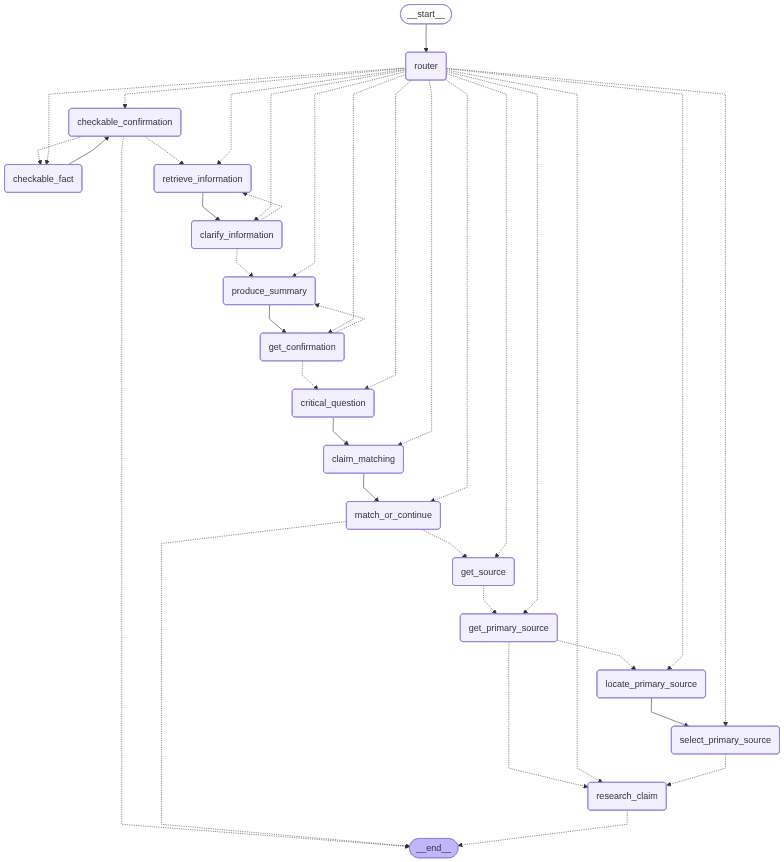

In [3]:
# ───────────────────────────────────────────────────────────────────────
# CLAIM GRAPH
# ───────────────────────────────────────────────────────────────────────
from claim_nodes import checkable_fact,checkable_confirmation,retrieve_information,clarify_information,produce_summary,get_confirmation
from langgraph.graph import StateGraph, START, END
from state_scope import AgentStateClaim

claim = StateGraph(AgentStateClaim)

claim.add_node("checkable_fact", checkable_fact)
claim.add_node("checkable_confirmation", checkable_confirmation)
claim.add_node("retrieve_information", retrieve_information)
claim.add_node("clarify_information", clarify_information)
claim.add_node("produce_summary", produce_summary)
claim.add_node("get_confirmation", get_confirmation)
claim.add_node("critical_question", critical_question)
claim.add_node("claim_matching", claim_matching)
claim.add_node("match_or_continue", match_or_continue)
claim.add_node("get_source", get_source)
claim.add_node("get_primary_source", get_primary_source)
claim.add_node("locate_primary_source", locate_primary_source)
claim.add_node("select_primary_source", select_primary_source)
claim.add_node("research_claim", research_claim)
claim.add_node("router", router)

# Entry point
claim.add_edge(START, "router")
claim.add_edge("checkable_fact", "checkable_confirmation")
claim.add_edge("retrieve_information", "clarify_information")
claim.add_edge("produce_summary", "get_confirmation")
claim.add_edge("critical_question", "claim_matching")
claim.add_edge("claim_matching", "match_or_continue")
claim.add_edge("locate_primary_source", "select_primary_source")
claim.add_edge("research_claim", END)

claim_flow = claim.compile()

#visualization
try:
    from IPython.display import Image, display
    display(Image(claim_flow.get_graph().draw_mermaid_png()))
except Exception:
    pass
